# User guide for Conformal Prediction Classification 
First of all you need to have `numpy`, `pandas` and `seaborn` installed to run this notebook with all examples. Secondly, the `plot_utils` code need to be on your PYTHONPATH, which can be performed in your terminal or programatically (as done here). The 'src' string in the code needs to be a valid path to the src-directory of the cloned git-repo for the code to run as expected.

In [1]:
#import sys
#!{sys.executable} -m pip install numpy pandas seaborn

In [2]:
# Make sure to add the code to your PYTHONPATH
import sys
sys.path.append('src')

Secondly we will import the packages required, both plotting/metrics and Numpy for loading and matplotlib for showing how to customize figures.

In [3]:
from pharmbio.cp import metrics, plotting
import matplotlib.pyplot as plt # For customizations 
import numpy as np # Loading of data

Import the results from a Conformal predictor. We require that the p-values are presented in a matrix format (either Numpy ndarray or Pandas DataFrame), and that the p-values for class '0' are in the first column (i.e. second dimension of the matrix), class '1' in second column etc. The true labels for the examples should be given either as a 1 dimension Numpy ndarray or a Pandas Series object, where the labels must be the same '0', '1', ... as used by the p-value matrix. 

In [4]:
# Binary test-case
my_data = np.genfromtxt('test/resources/transporters.p-values.csv', delimiter=';', skip_header=1)
true_labels = np.array([1 if x == 1.0 else 0 for x in my_data[:,1]])
p_values=my_data[:,[2,3]]
print(p_values.shape)

(233, 2)


In [5]:
# Multiclass test-case
from sklearn.datasets import load_iris
multiclass_target_names = load_iris().target_names
multiclass_data = np.genfromtxt('test/resources/multiclass.csv', delimiter=',')
# this file has first column as the true label and the remaining ones are p-values
multiclass_p_values = multiclass_data[:,1:]
multiclass_true_labels = multiclass_data[:,:1].astype(np.int)
print(multiclass_p_values.shape) # 3 columns - 3 classes

(50, 3)


## Compute metrics
Here are a few examples of metrics that can be computed, all located in the package `pharmbio.cp.metrics`.

In [6]:
# Calculate the fraction of errors for a set of significance levels
# Output ordered in the same order as the `sign_vals` input.
# First index of the tuple is the overall fraction of errors, then comes
# a matrix with errors for each class (one row per significance, one column per class)
metrics.frac_errors(true_labels, p_values, sign_vals=[.15,.25])

(array([0.12017167, 0.18454936]),
 array([[0.16      , 0.07407407],
        [0.24      , 0.12037037]]))

In [7]:
metrics.obs_fuzziness(true_labels, p_values)

0.1360179639484979

In [8]:
CM = metrics.confusion_matrix(true_labels, p_values, sign=0.2, labels=[-1,1])
CM

,-1,1
-1,80,9
1,25,94
Empty,0,0
Both,20,5


In [9]:
CM_multiclass = metrics.confusion_matrix(multiclass_true_labels, multiclass_p_values, sign=0.02, labels=multiclass_target_names)
CM_multiclass

,setosa,versicolor,virginica
setosa,19,0,0
versicolor,0,13,0
virginica,0,2,15
Empty,0,0,0
Correct Multi-set,0,1,0
Incorrect Multi-set,0,0,0


## Plotting calibration curves

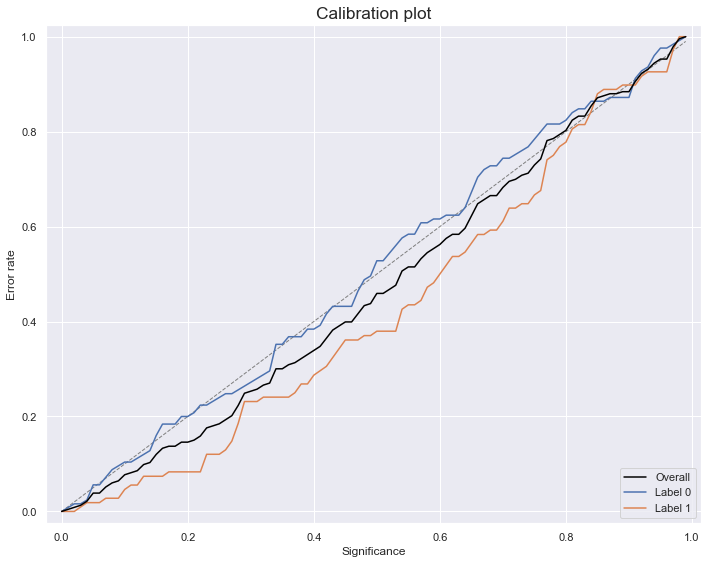

In [10]:
the_fig = plotting.plot_calibration_curve(true_labels, p_values, title='Calibration plot')

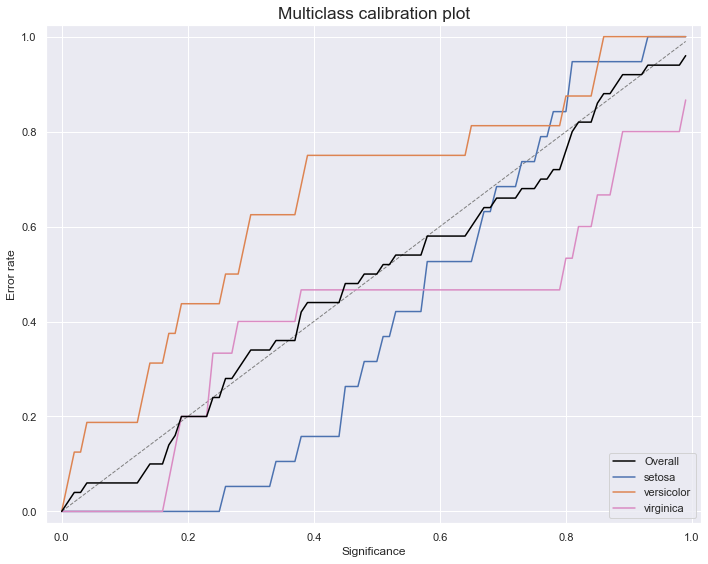

In [11]:
mutliclass_fig = plotting.plot_calibration_curve(multiclass_true_labels, 
                                                 multiclass_p_values, 
                                                 title='Multiclass calibration plot', 
                                                 labels=multiclass_target_names)


Plotting can also be done in a smaller range of significance values and has a few parameters to tweak the generated figure

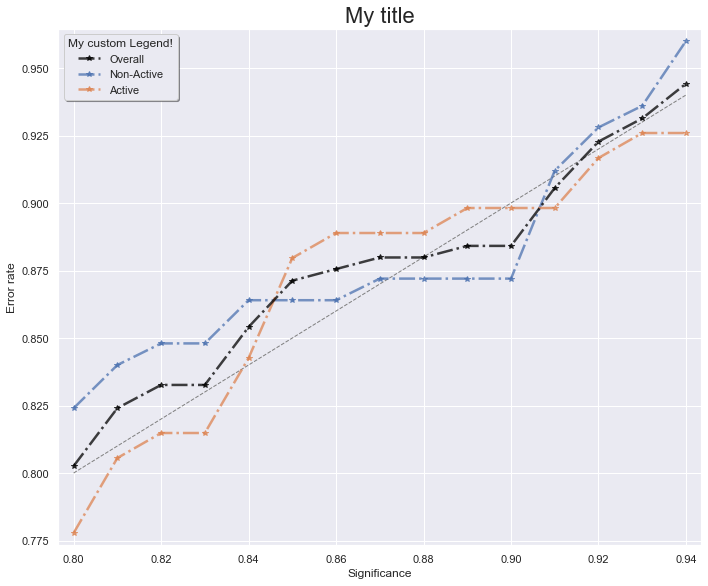

In [12]:
line_args = {'alpha': 0.75, 'marker':"*", 'linestyle': '-.', 'linewidth':2.5}

the_fig = plotting.plot_calibration_curve(true_labels, 
                                          p_values,
                                          sign_vals=np.arange(0.8,0.95,0.01),
                                          chart_padding=0.025,
                                          labels=["Non-Active", "Active"], 
                                          **line_args)

# Get the axes to make customizations on
axes = the_fig.axes[0]

# Set a custom title
axes.set_title('My title', fontsize=22)

# Add a new (custom) legend
axes.legend(shadow=True,title='My custom Legend!')

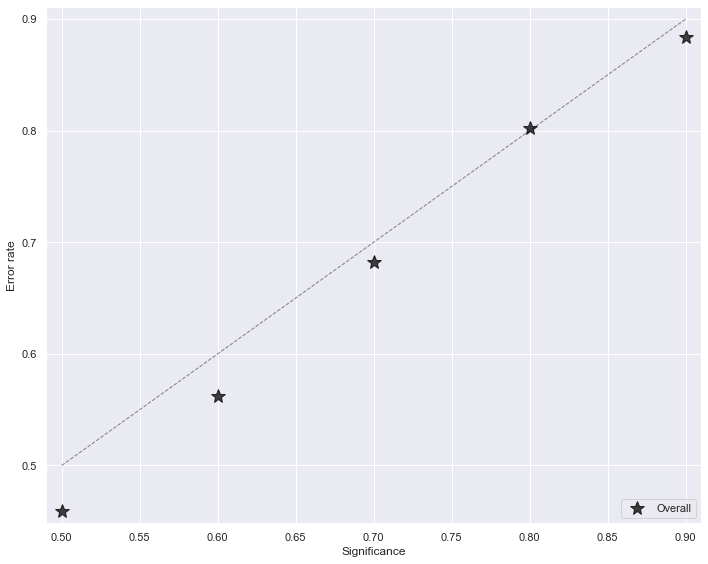

In [13]:
line_args = {'alpha': 0.75, 'marker':"*", 'ms': 15,'linestyle': 'None'}

the_fig = plotting.plot_calibration_curve(true_labels, 
                                          p_values, 
                                          sign_vals=np.arange(0.5,1,0.1), 
                                          labels=["Non-Active", "Active"],
                                          plot_all_labels=False, 
                                          **line_args)

You can generate a calibration plot for a single class in many different ways (2 simple ways are):
- by only sending examples for that class and use the 'overall' curve
- specify the other colors with 0 alpha value (i.e. transparent)

Here we show the first of these alternatives

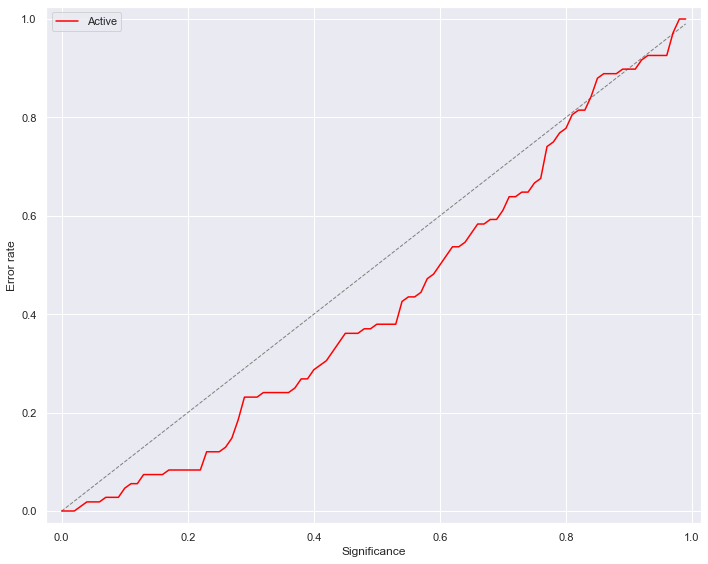

In [14]:
only_class_1 = (true_labels == 1)
true_1 = true_labels[only_class_1]
p_val_1 = p_values[only_class_1]
the_fig = plotting.plot_calibration_curve(true_1, p_val_1, 
                                          overall_color="red",
                                         plot_all_labels=False) 
# The legend specifies the curve as 'overall' - change this to the correct label name
the_fig.axes[0].legend().get_texts()[0].set_text('Active')

## Plotting p-values against each other

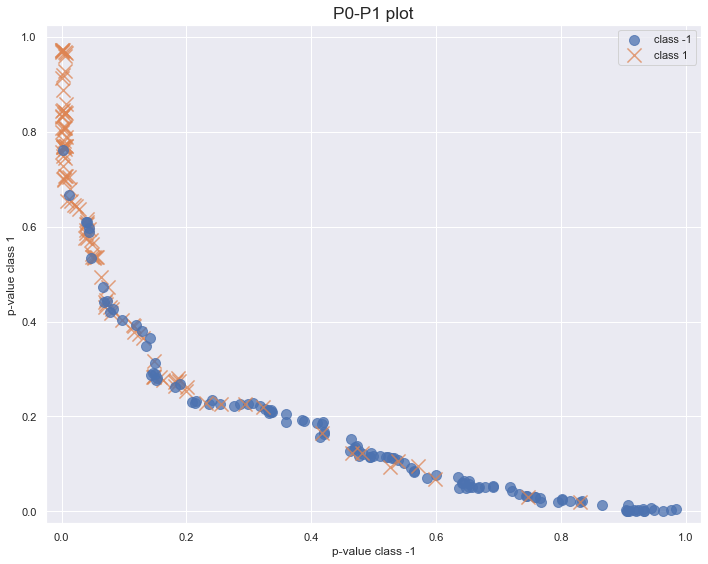

In [15]:
kwargs = {'alpha': 0.75} #, 'linewidth': 10} #, 'fontsize': 30}
font_args = None #{'fontsize':30}
marks = ['o','x']
s = [100, 200]
p0p1 = plotting.plot_pvalues(true_labels, 
                             p_values, 
                             title='P0-P1 plot',
                             sizes=s, 
                             markers=marks, 
                             labels=['class -1', 'class 1'],
                             fontargs=font_args,
                             **kwargs)


## Plotting the distribution of prediction sets 

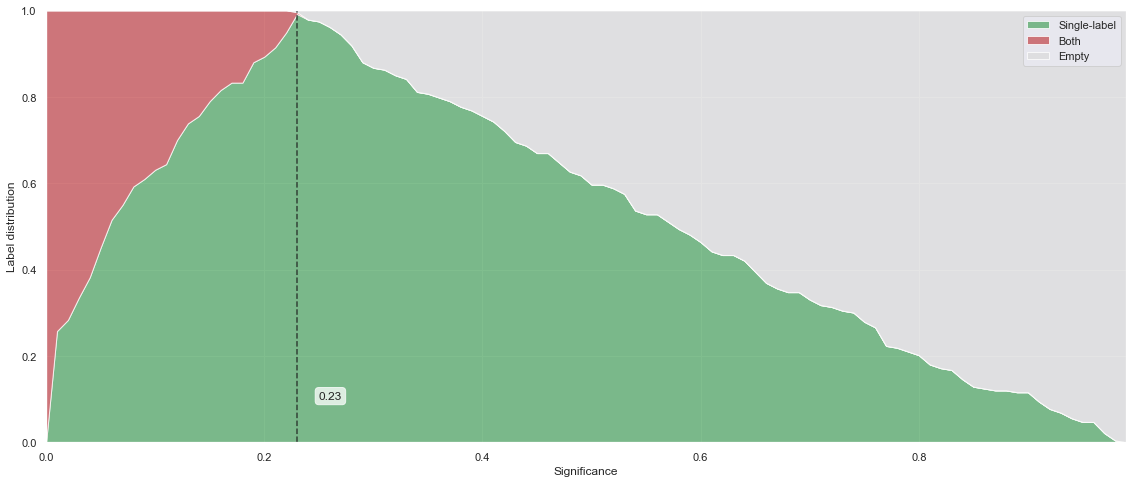

In [16]:
my_fig = plt.figure(figsize=(15,6))
ax = my_fig.add_axes([0,0,1,1])
custom_args = {'alpha': 0.75}
fig = plotting.plot_label_distribution(true_labels, p_values, tight_layout=False, ax=ax, **custom_args)
# my_fig.savefig('area-plot.png',bbox_inches='tight')

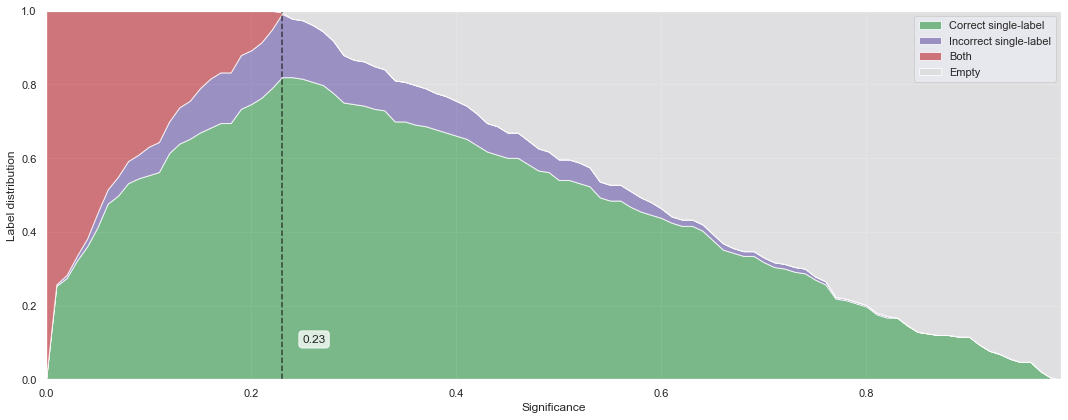

In [17]:
fig = plotting.plot_label_distribution(true_labels, 
                                       p_values, 
                                       figsize=(15,6),
                                       display_incorrects=True, 
                                       **custom_args)

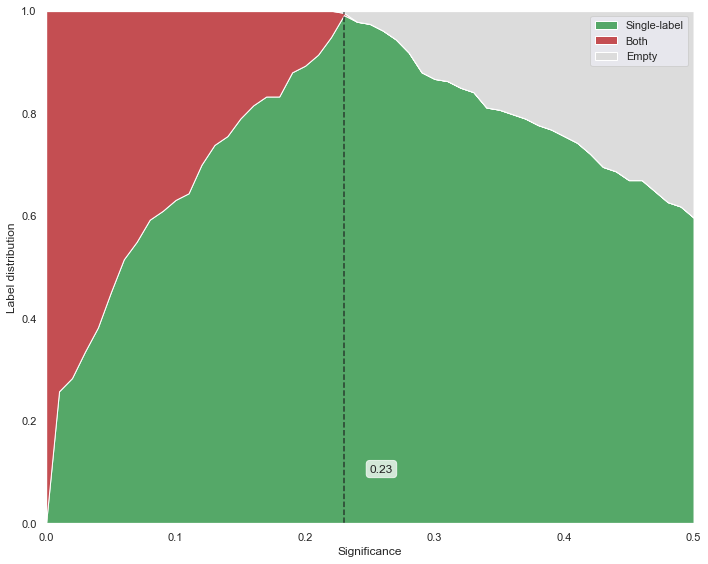

In [18]:
fig = plotting.plot_label_distribution(true_labels, p_values, sign_vals=np.arange(0,.51,0.01))

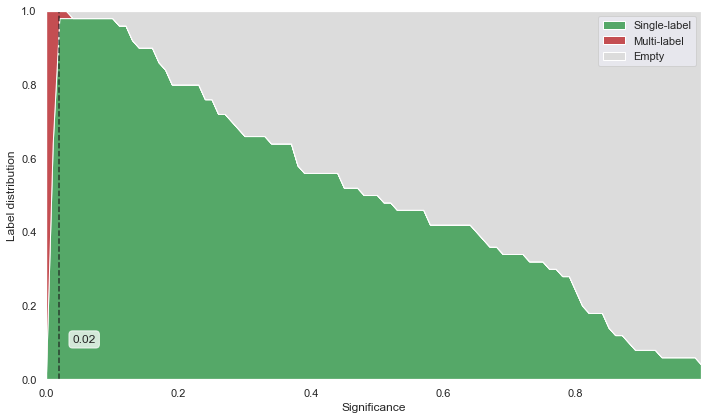

In [19]:
fig_multiclass = plotting.plot_label_distribution(multiclass_true_labels, 
                                                  multiclass_p_values, 
                                                  figsize=(10,6))

## Plotting predictions using Bubble plots

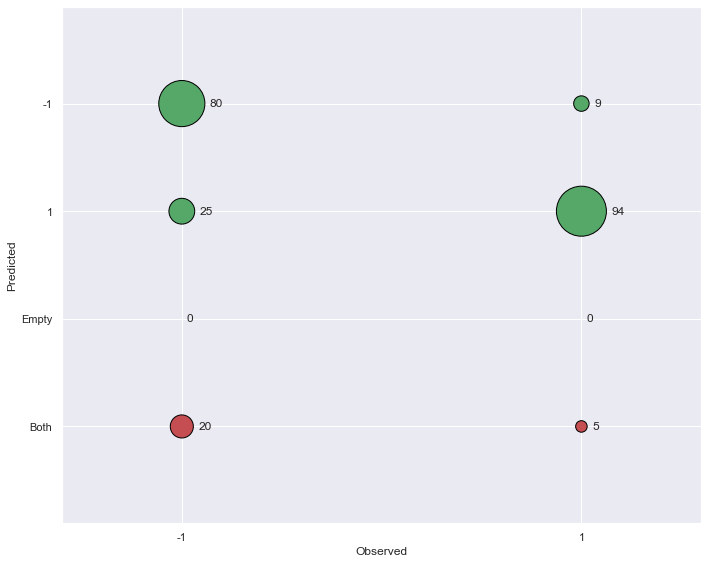

In [20]:
# We can use the confusion matrix computed earlier
bubble_plot = plotting.plot_confusion_matrix_bubbles(confusion_matrix=CM)

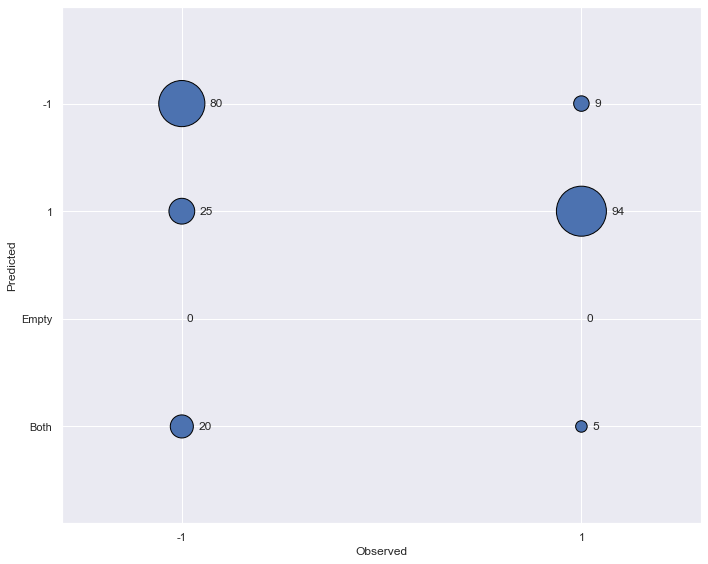

In [21]:
bubble_plot_none = plotting.plot_confusion_matrix_bubbles(confusion_matrix=CM, color_scheme=None)

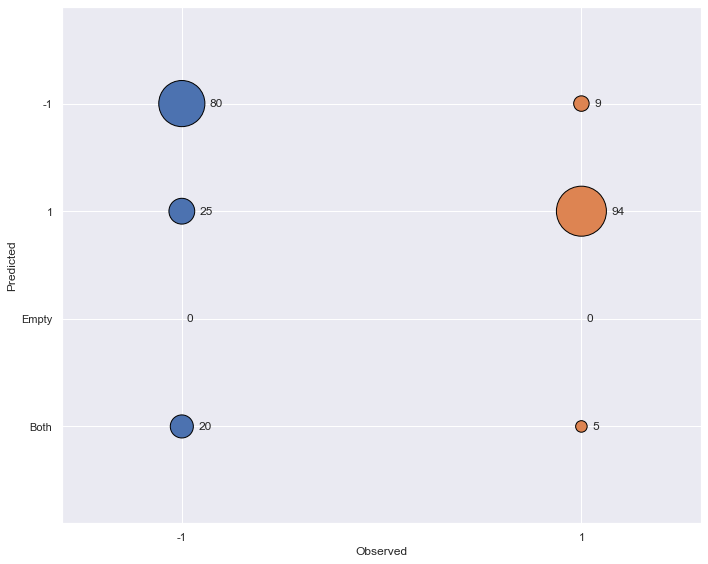

In [22]:
bubble_plot_label = plotting.plot_confusion_matrix_bubbles(confusion_matrix=CM, color_scheme='label')

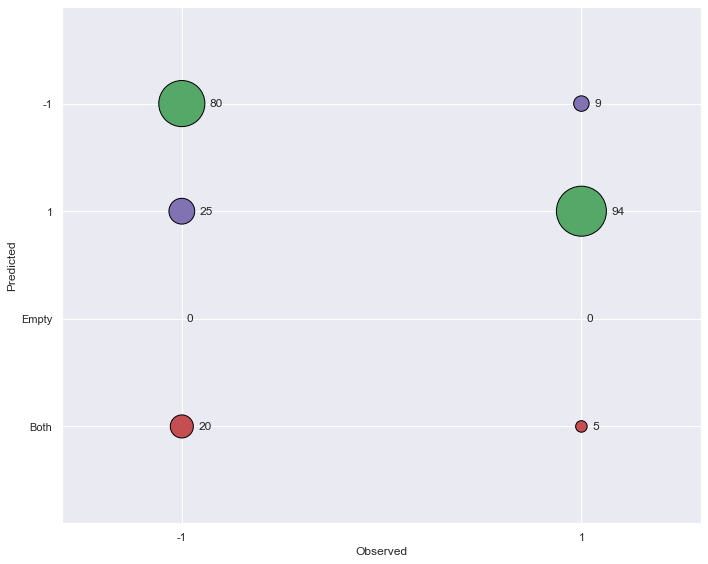

In [23]:
bubble_plot_label = plotting.plot_confusion_matrix_bubbles(confusion_matrix=CM, 
                                                           color_scheme='full')

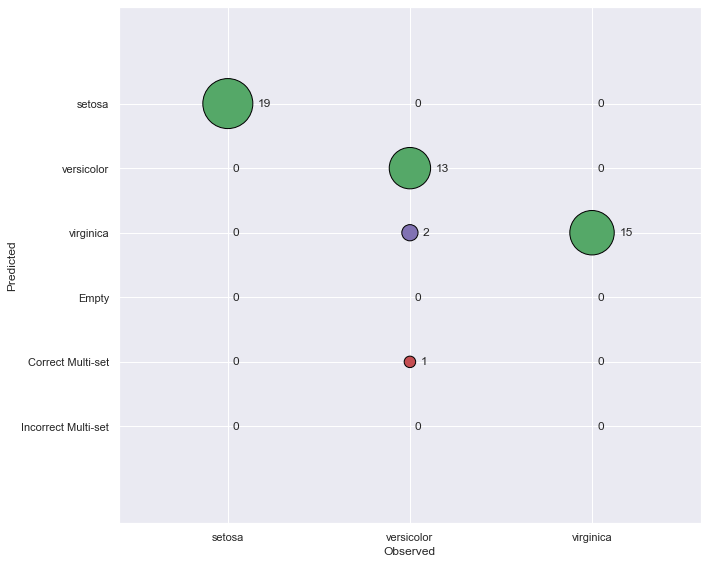

In [24]:
bubble_plot_label_multi = plotting.plot_confusion_matrix_bubbles(confusion_matrix=CM_multiclass, 
                                                                 color_scheme='full')

Text(0.5, 1.0, 'Bubble plot')

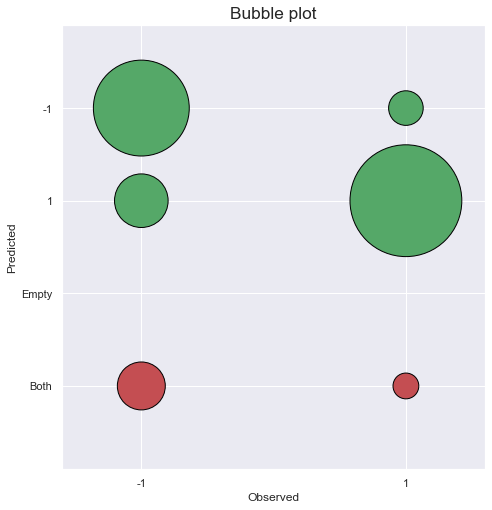

In [25]:
# Compute a normalized confusion matrix where each column sum to 1
CM_norm = metrics.confusion_matrix(true_labels, p_values, sign=0.2,
                                   labels=[-1,1], normalize_per_class=True)
# Remove the annotations and increase the size of the bubbles
bubble_plot_norm = plotting.plot_confusion_matrix_bubbles(confusion_matrix=CM_norm, 
                                                          annotate=False, 
                                                          scale_factor=5,
                                                          figsize=7) # figure will be a 7x7 square 

bubble_plot_norm.axes[0].set_title('Bubble plot', fontdict={'fontsize': 'x-large'})

## Plotting heatmaps of a confusion matrix

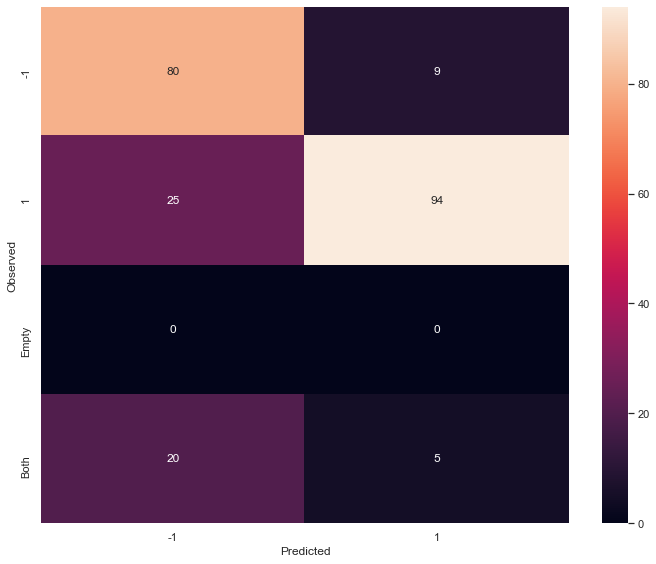

In [26]:
heat_m = plotting.plot_confusion_matrix_heatmap(CM)

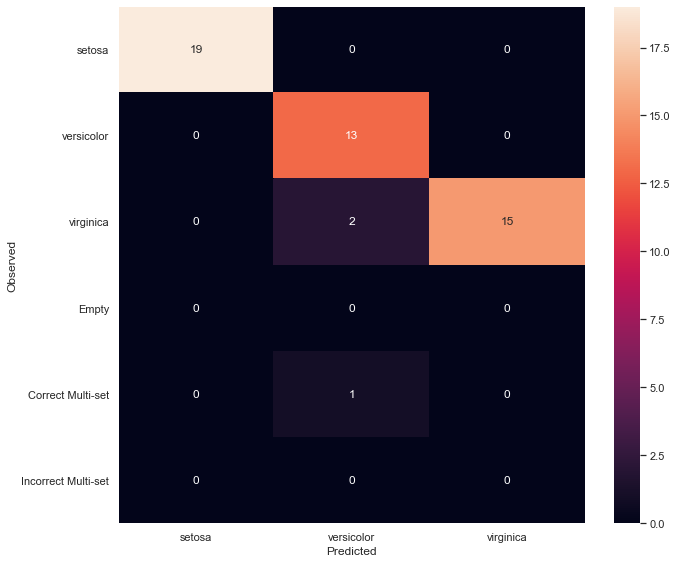

In [27]:
heat_m_multi = plotting.plot_confusion_matrix_heatmap(CM_multiclass)

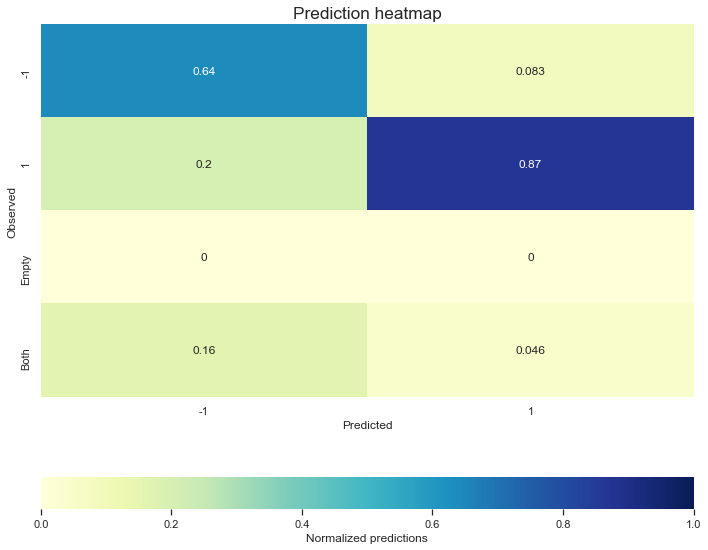

In [28]:
extra_args = {'vmax': 1,'cmap':"YlGnBu"} 
cbar_kws = {"orientation": "horizontal", 'label': 'Normalized predictions'}
heat_m_norm = plotting.plot_confusion_matrix_heatmap(CM_norm, title="Prediction heatmap",
                                                     cbar_kws=cbar_kws,**extra_args)

## Example of joining mutliple plots in a grid

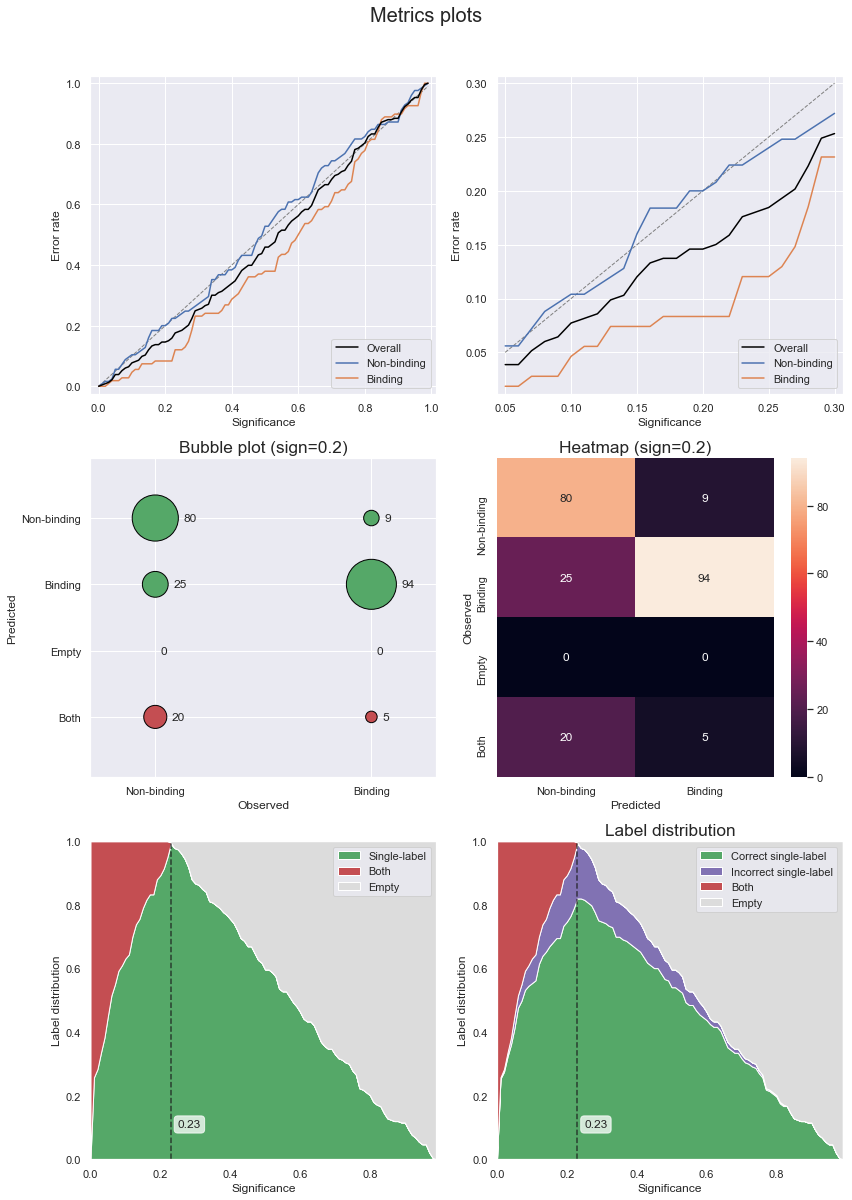

In [29]:
fig, axes = plt.subplots(3,2, figsize=(12,17))
class_labels=['Non-binding','Binding']
# Calibration plot
plotting.plot_calibration_curve(true_labels, p_values, ax=axes[0,0], labels=class_labels)
#70-95% confidence only
plotting.plot_calibration_curve(true_labels, p_values, ax=axes[0,1], sign_vals=np.arange(0.05,0.31,0.01), chart_padding=.025, labels=class_labels) 
plotting.plot_confusion_matrix_bubbles(metrics.confusion_matrix(true_labels,p_values, .2, labels=class_labels),title="Bubble plot (sign=0.2)", ax=axes[1,0])
plotting.plot_confusion_matrix_heatmap(metrics.confusion_matrix(true_labels,p_values, .2, labels=class_labels), ax=axes[1,1], title="Heatmap (sign=0.2)")
plotting.plot_label_distribution(true_labels,p_values, ax=axes[2,0])
plotting.plot_label_distribution(true_labels,p_values, ax=axes[2,1], display_incorrects=True, title='Label distribution')
fig.suptitle('Metrics plots', fontsize=20)
fig.tight_layout(rect=[0, 0, 1, 0.96])